## 1. Understanding the Business Problem
In this problem we need to classify whether given a pair of questions are similar or not i.e. do they mean the same thing.

The main business constraints are:
1. The cost of mis-classification can be very high.
2. A probability value for pair of questions is important. For instance, only pair the question if the probability of two questions being similar is greater than P(Q1~Q2)>x, where x being a value of probability.
3. No latency requirement
4. Interpretibility is partially important.

## 2. Data Overview

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import distance
import os

import re
import time
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from os import path
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('train.csv')
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

**There are 6 Columns/features in this dataset and most important are 'question1', 'question2' 'is_duplicate'. As they give most information about the business problem.**

In [3]:
print('Number of Data points :', df.shape[0])

Number of Data points : 404290


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## 3. EDA 

### Distribution of Output point in the dataset

<AxesSubplot:xlabel='is_duplicate'>

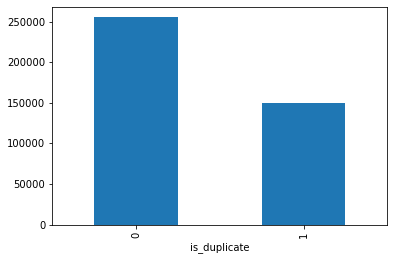

In [5]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [6]:
print('Total number of question pairs for training:\n   {}'.format(len(df)))
print('Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training:
   404290
Question pairs are not Similar (is_duplicate = 0):
   63.08%
Question pairs are Similar (is_duplicate = 1):
   36.92%


**It is an imbalanced dataset**

### Number of unique questions

In [7]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

q_vals = qids.value_counts()
q_vals = q_vals.values

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


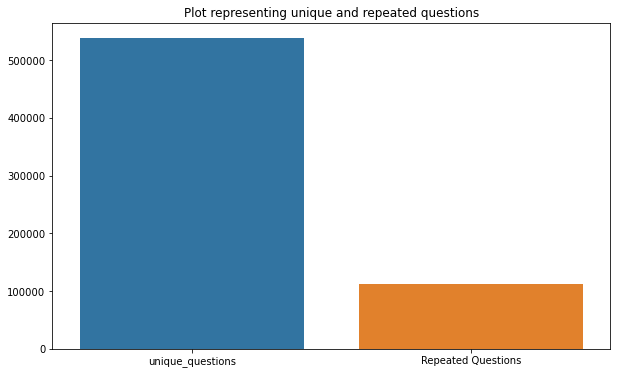

In [8]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x = x, y = y)
plt.show()

### Checking for Duplicates

In [9]:
# Checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions", (pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### Number of occurrences of each question

Maximum number of times a single question is repeated: 157



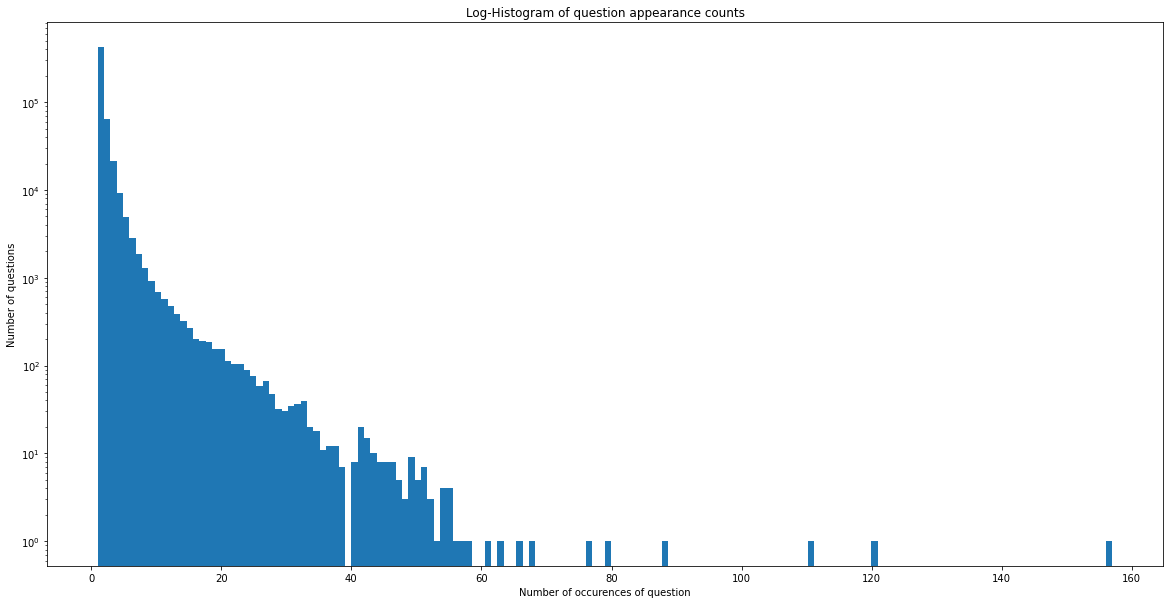

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### Checking for NULL values

In [11]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [12]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 4. Feature Extraction before cleaning or feature engineering.

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [13]:
import os
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

 ### Analysis of some of the extracted features

In [14]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### Feature: word_share

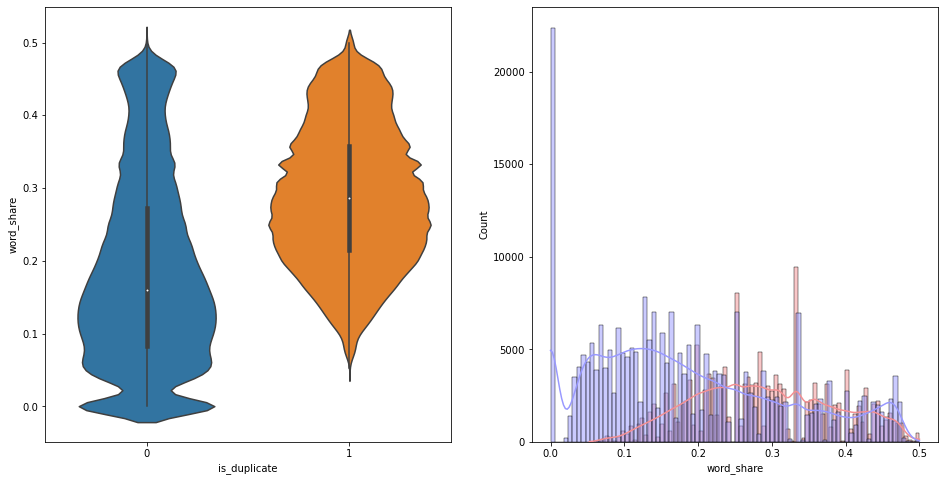

In [15]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , kde = True, label = "1", color = '#f49093')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , kde = True, label = "0" , color = '#9999ff')
plt.show()

#### Feature: word_Common¶


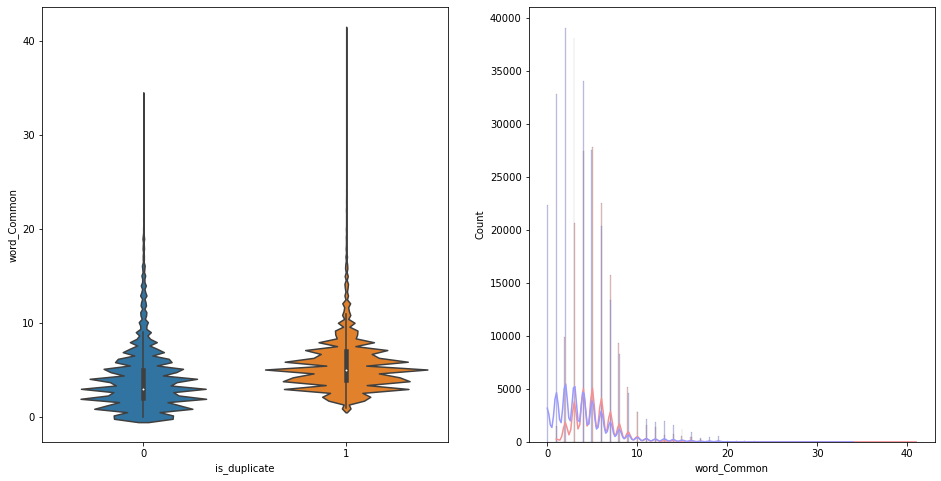

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , kde = True, label = "1", color = '#f49093')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , kde = True, label = "0" , color = '#9999ff')
plt.show()

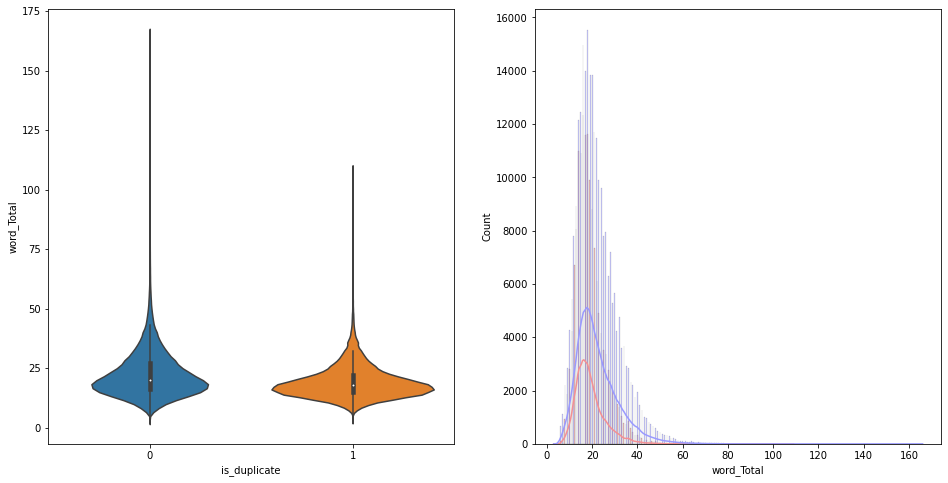

In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , kde = True, label = "1", color = '#f49093')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , kde = True, label = "0" , color = '#9999ff')
plt.show()

**From the above EDA we could not figure out the important feature as there is too much overlap and hence going for the Advance feature extraction.**

## 5. Preprocessing of Text

- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
       .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
       .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
       .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
       .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
       .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
       .replace("€", " euro ").replace("'ll", " will") #Expanding Contractions
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

## 6. Advance Feature Extraction

Definition:

- Token: You get a token by splitting sentence with the space character
- Stop_Word : stop words as per NLTK.
- Word : A token that is not a stop_word

**Features:**

- cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2                                               
  cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
- cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2                                               
  cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
- csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2                                               
  csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
- csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2                                               
  csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
- ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2                                             
  ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
- ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2                                             
  ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
- last_word_eq : Check if the last word of both questions is equal or not                                                       
  last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
- first_word_eq : Check if the first word of both questions is equal or not                                                     
  first_word_eq = int(q1_tokens[0] == q2_tokens[0])
- abs_len_diff : Abs. length difference                                                                                         
  abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
- mean_len : Average Token Length of both Questions                                                                             
  mean_len = (len(q1_tokens) + len(q2_tokens))/2
- fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage                                                                     
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage                                                             
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage                                                               
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage                                                               
  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2                   
  longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [19]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# Get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # Pre-processing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    # Computing Fuzzy Features and Merging with Dataset
    # Do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [20]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv", encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)

df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

### Analysis of extracted features

- Creating Word Cloud of Duplicate and Non-Duplicate Question pairs
- We can observe the most frequently occuring words in Duplicate Question pairs and Non-Duplicate Question pairs.
- Based on the below word-clouds, we can conclude that there are certain words that occur more frequently in duplicate pair of questions than non-duplicate pair of questions, and vice-versa.
- Also, there are certain words that occur with almost the same frequency, in both duplicate as well as non-duplicate pair of questions.

In [21]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

# Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [22]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

# Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [23]:
# Reading the text files and removing the Stop Words:
from wordcloud import WordCloud, STOPWORDS
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'), encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
# stopwords.remove("good")
# stopwords.remove("love")
stopwords.remove("like")
# stopwords.remove("best")
# stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


Word Cloud for Duplicate Question pairs


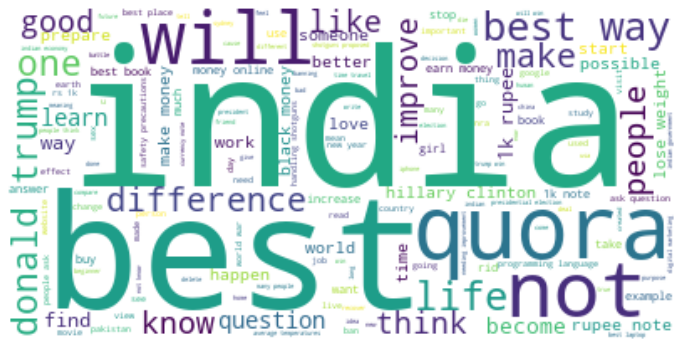

In [24]:
# Word Clouds generated from duplicate pair question's text
plt.figure(figsize = (12, 10))
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


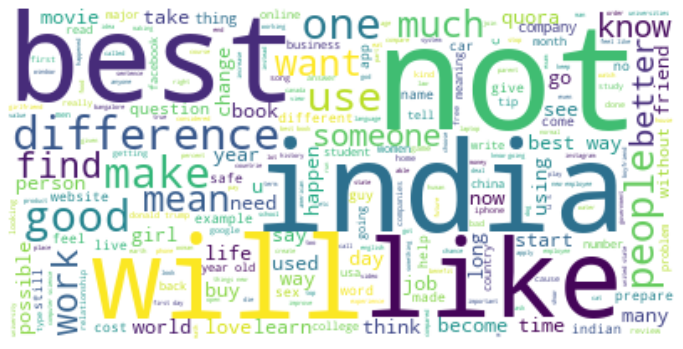

In [25]:
# Word Clouds generated from non duplicate pair question's text
plt.figure(figsize = (12, 10))
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

####  Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

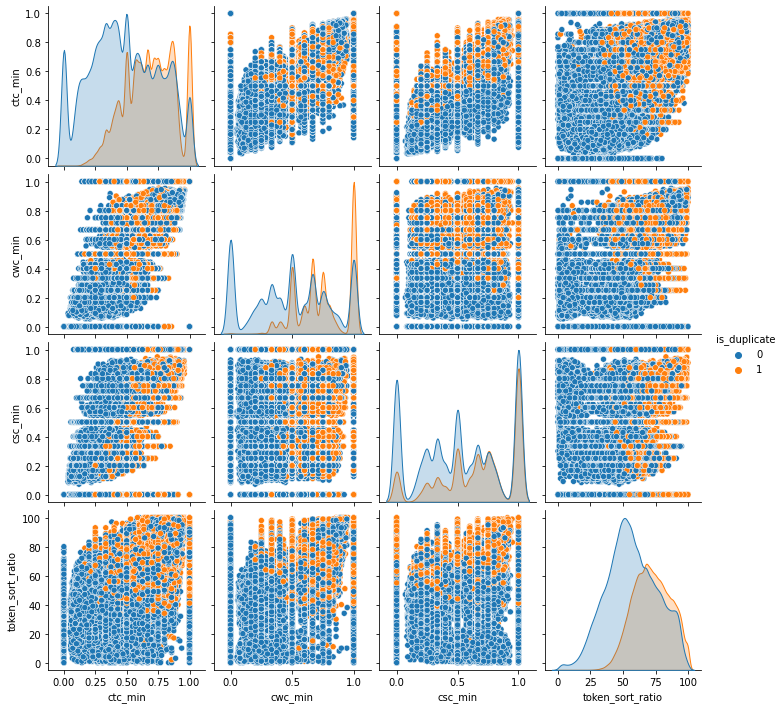

In [26]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

**Here we can see too much of overlapping. Hence, we cannot easily classify using Linear Algebra concepts. Using Advanced t-SNE for better results.**

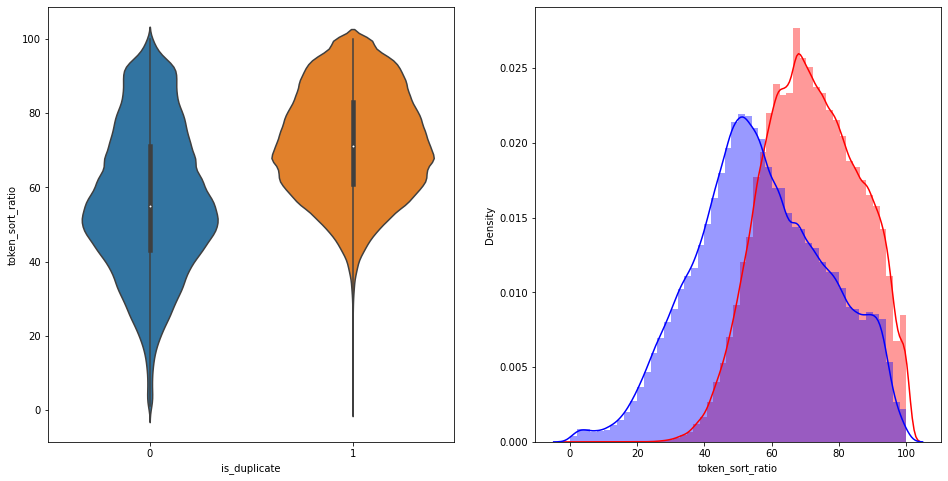

In [27]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

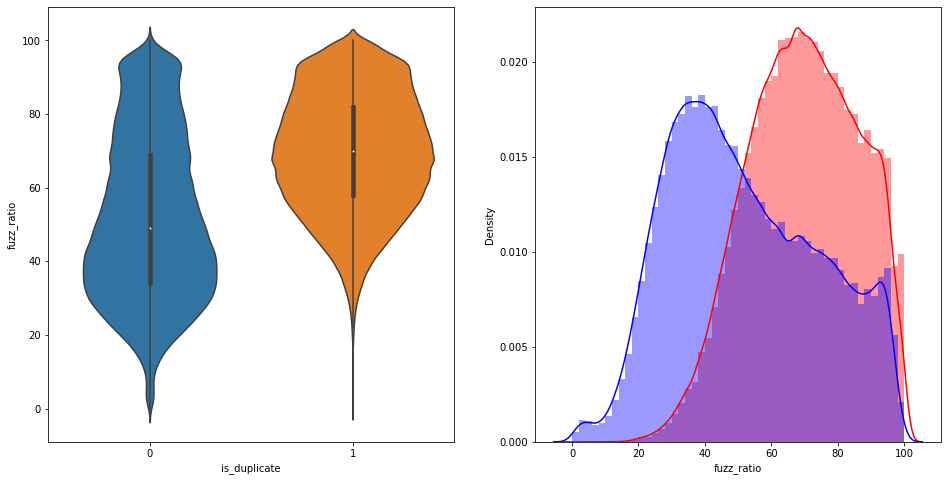

In [28]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## 7. Visualization

In [29]:
# Using TSNE for Dimentionality reduction for 15 Features
from sklearn.preprocessing import MinMaxScaler
#Normalising Data
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[[
    'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 
    'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',  
    'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']
])
y = dfp_subsampled['is_duplicate'].values

In [30]:
#2d
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.419s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.237s
[t-SNE] Iteration 50: error = 81.3220596, gradient norm = 0.0456050 (50 iterations in 1.869s)
[t-SNE] Iteration 100: error = 70.6558304, gradient norm = 0.0089307 (50 iterations in 1.454s)
[t-SNE] Iteration 150: error = 68.9428329, gradient norm = 0.0055120 (50 iterations in 1.471s)
[t-SNE] Iteration 200: error = 68.1361694, gradient norm = 0.0043893 (50 iterations in 1.525s)
[t-SNE] Iteration 250: error = 67.6280594, gradient norm = 0.0038229

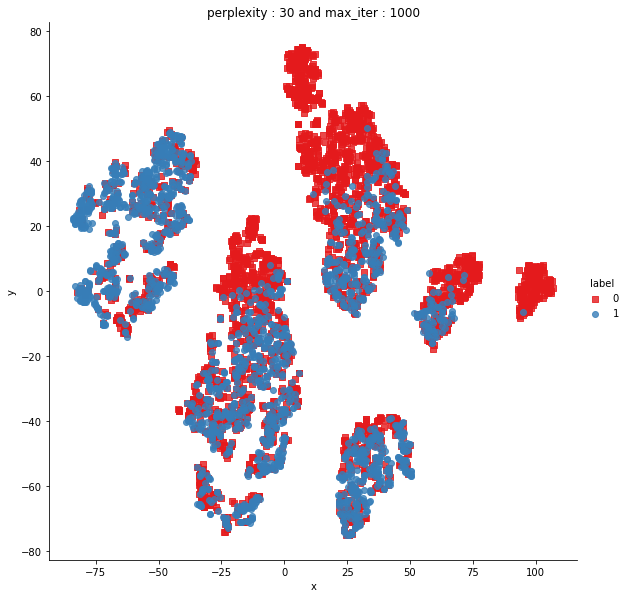

In [31]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# Draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,
   palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [32]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.029s...
[t-SNE] Computed neighbors for 5000 samples in 0.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.242s
[t-SNE] Iteration 50: error = 80.5631256, gradient norm = 0.0313357 (50 iterations in 4.196s)
[t-SNE] Iteration 100: error = 69.4188385, gradient norm = 0.0036464 (50 iterations in 2.780s)
[t-SNE] Iteration 150: error = 68.0113144, gradient norm = 0.0017043 (50 iterations in 2.440s)
[t-SNE] Iteration 200: error = 67.4470215, gradient norm = 0.0011665 (50 iterations in 2.355s)
[t-SNE] Iteration 250: error = 67.1339722, gradient norm = 0.0010371

In [33]:
# 3d Scatter plot
import plotly.offline as py
import plotly.graph_objs as go
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## 8. Featurizing text data with tfidf weighted word-vectors

- From our previous analysis, we realized that some words occur more often in class 1 pairs, while some words occur more often in class 0 pairs.
- So, the question is can we use this realization somehow to construct text-based features? We know both TF-IDF and Word2Vec techniques. However, instead of using W2V, we will be usibg GLoVE for this problem.
- GLoVE is very similar to W2V, in that it helps us to convert words into vectors while maintaining the semantic relationships among words. The only difference is in the way they work.

In [34]:
df = pd.read_csv("train.csv.zip")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [35]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [36]:
# Merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.- 
- Here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [37]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
nlp = spacy.load('en_core_web_sm')
vecs1 = []

# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # Word2Vec
        vec1 = word1.vector
        # Fetch df score
        try: idf = word2tfidf[str(word1)]
        except: idf = 0
        # Compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [48:36<00:00, 138.63it/s]


In [38]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # Word2Vec
        vec2 = word2.vector
        # Fetch df score
        try: idf = word2tfidf[str(word2)]
        except: idf = 0
        # Compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [45:56<00:00, 146.66it/s]


In [67]:
# prepro_features_train.csv (Simple Preprocessing Feartures)
# nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("Download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("Download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

- So, the final feature vector(s) or x_i(s) consists of 4 parts. The 1st part consists of the features provided to us in the original dataset, and the ones we engineered in the Basic Feature Extraction Section .
- The 2nd part consists of the 15 features that we engineered in the Advanced Feature Extraction Section.
- The 3rd part consists of the TF-IDF Weighted GLoVE representation of the Question 1, and the 4th part consists of the TF-IDF Weighted GLoVE representation of the Question 2.

In [68]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [69]:
df1.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   
2   2             0  0.399992  0.333328  0.399992  0.249997  0.399996   
3   3             0  0.000000  0.000000  0.000000  0.000000  0.000000   
4   4             0  0.399992  0.199998  0.999950  0.666644  0.571420   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   
2  0.285712           0.0            1.0           4.0      12.0   
3  0.000000           0.0            0.0           2.0      12.0   
4  0.307690           0.0            1.0           6.0      10.0   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   
2               63                63          43                  47   
3               28                24           9                  14   
4               67                47          35                  56   

   longest_substr_ratio  
0              0.982759  
1              0.596154  
2              0.166667  
3              0.039216  
4              0.175000

In [70]:
df2.head()

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0   0          1          1     66     57          14          12   
1   1          4          1     51     88           8          13   
2   2          1          1     73     59          14          10   
3   3          1          1     50     65          11           9   
4   4          3          1     76     39          13           7   

   word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
0         10.0        23.0    0.434783           2           0  
1          4.0        20.0    0.200000           5           3  
2          4.0        24.0    0.166667           2           0  
3          0.0        19.0    0.000000           2           0  
4          2.0        20.0    0.100000           4           2

In [71]:
df3_q1.head()

0          1          2          3          4          5   \
0  18.807843  41.964926  33.081681   4.244238  43.027659 -10.013383   
1 -23.079738  14.342906  -0.805506 -19.245326   8.865776  -9.310454   
2  -0.112307  18.152627  17.287431  23.381115  25.388425  -6.092771   
3 -22.978012   3.542216 -21.203833   6.316206  11.723298  11.653462   
4  47.606715  76.045652 -16.103146  25.784890   4.649403 -14.228687   

          6          7          8          9   ...         86         87  \
0 -10.744927 -11.815859   5.588288   1.115522  ...  20.576247 -21.568797   
1 -16.653165 -13.512745   3.500085  -3.910091  ...  53.702352  13.131150   
2 -20.567529 -15.121522  -2.940608  16.324171  ...  -2.378785  -2.544791   
3 -29.423875   2.754801 -17.613957 -12.570249  ... -25.697054 -17.881601   
4 -42.204426  32.545716   4.067297 -16.961617  ...  22.576464 -35.968549   

          88         89         90         91         92         93  \
0 -24.228453  14.157065 -16.261115  25.544021  25.480808  39.165071   
1 -22.455495 -54.181957   0.183353  -3.724258 -12.677888  19.355100   
2 -10.461190  16.518055 -21.963829  22.504434   2.132555   8.428122   
3 -30.913518   1.010653   8.655211  22.253350  -7.253639  18.266633   
4 -19.760356 -52.964732 -60.509826  20.788706  45.909070  44.480312   

          94         95  
0   3.834185   9.871860  
1  11.162901  19.004885  
2  27.520017 -22.875334  
3  51.872220   6.351798  
4 -28.241497  18.110361  

[5 rows x 96 columns]

In [72]:
df3_q2.head()

0          1          2          3          4          5   \
0  18.710824  37.375986  45.405516   5.426995  33.751131  -3.253420   
1 -13.239171  38.161040  31.628311  -9.844968  17.468515 -19.613922   
2   1.774256  41.910379  11.486097  -2.761912  31.372257  -0.054157   
3   5.639871  15.257331   8.393493  34.085459  17.597781   2.442303   
4   9.878437  30.031709  29.496887   0.223323  16.194255   7.182570   

          6          7          8          9   ...         86         87  \
0  -4.959911 -13.442803   3.905695   4.777382  ...  23.793560 -20.588538   
1 -16.775893   1.972479  -5.051891   6.606223  ...  68.032528   1.352752   
2 -33.715000   9.834838  -8.615697 -18.969312  ... -10.696379 -35.324791   
3 -16.274006   0.360628 -10.255298 -14.794721  ...   6.891580 -21.247972   
4 -18.419677   6.949175  11.067374   7.980174  ...  17.671461 -11.538394   

          88         89         90         91         92         93  \
0 -25.390728  12.380474 -19.671300  16.618838  30.438979  43.384339   
1 -25.395078  -7.580498 -23.430201   3.710806   1.435839  44.218947   
2 -20.233565  40.031800 -22.515539  12.892510   0.084740  21.583779   
3   0.394724  41.386917  -9.613216  18.265161  -1.723291   1.429064   
4 -11.433049  14.088319 -32.659020   6.244056  20.535059  17.647714   

          94         95  
0   5.521896   2.243536  
1  11.410592  22.943373  
2  24.523905  -7.576786  
3  18.121417  18.179006  
4  12.484857 -12.859808  

[5 rows x 96 columns]

In [73]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [77]:
# Storing the final features to CSV file
if os.path.isfile('final_features_sm.csv'):
    df3_q1['id'] = df1['id']
    df3_q2['id'] = df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features_sm.csv')

In [78]:
data = pd.DataFrame(result).copy()
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
# data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)
data.drop(['id','is_duplicate'], axis=1, inplace=True)

## 9. ML Modeling

In [79]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss
import math
import xgboost as xgb

In [80]:
data.head()

cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  last_word_eq  \
1  0.799984  0.399996  0.749981  0.599988  0.699993  0.466664           0.0   
2  0.399992  0.333328  0.399992  0.249997  0.399996  0.285712           0.0   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000           0.0   
4  0.399992  0.199998  0.999950  0.666644  0.571420  0.307690           0.0   
5  0.666656  0.571420  0.888879  0.799992  0.705878  0.705878           1.0   

   first_word_eq  abs_len_diff  mean_len  ...       86_y       87_y  \
1            1.0           5.0      12.5  ...  68.032528   1.352752   
2            1.0           4.0      12.0  ... -10.696379 -35.324791   
3            0.0           2.0      12.0  ...   6.891580 -21.247972   
4            1.0           6.0      10.0  ...  17.671461 -11.538394   
5            0.0           0.0      17.0  ...  23.299828  23.817801   

        88_y       89_y       90_y       91_y       92_y       93_y  \
1 -25.395078  -7.580498 -23.430201   3.710806   1.435839  44.218947   
2 -20.233565  40.031800 -22.515539  12.892510   0.084740  21.583779   
3   0.394724  41.386917  -9.613216  18.265161  -1.723291   1.429064   
4 -11.433049  14.088319 -32.659020   6.244056  20.535059  17.647714   
5 -24.890131 -56.927054  -2.215075  52.634251 -14.493708  22.898442   

        94_y       95_y  
1  11.410592  22.943373  
2  24.523905  -7.576786  
3  18.121417  18.179006  
4  12.484857 -12.859808  
5 -15.336361  47.136550  

[5 rows x 218 columns]

In [81]:
pd.set_option('display.max_columns', None)
data

cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  \
1       0.799984  0.399996  0.749981  0.599988  0.699993  0.466664   
2       0.399992  0.333328  0.399992  0.249997  0.399996  0.285712   
3       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4       0.399992  0.199998  0.999950  0.666644  0.571420  0.307690   
5       0.666656  0.571420  0.888879  0.799992  0.705878  0.705878   
...          ...       ...       ...       ...       ...       ...   
404285  0.857131  0.857131  0.999980  0.833319  0.846147  0.785709   
404286  0.666644  0.666644  0.599988  0.599988  0.624992  0.555549   
404287  0.999900  0.499975  0.999950  0.666644  0.749981  0.749981   
404288  0.000000  0.000000  0.124998  0.099999  0.058823  0.040000   
404289  0.999967  0.999967  0.999980  0.714276  0.999988  0.799992   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  token_set_ratio  \
1                0.0            1.0           5.0      12.5               86   
2                0.0            1.0           4.0      12.0               63   
3                0.0            0.0           2.0      12.0               28   
4                0.0            1.0           6.0      10.0               67   
5                1.0            0.0           0.0      17.0               81   
...              ...            ...           ...       ...              ...   
404285           1.0            1.0           1.0      13.5               97   
404286           1.0            0.0           1.0       8.5               79   
404287           1.0            1.0           0.0       4.0               86   
404288           0.0            0.0           8.0      21.0               37   
404289           1.0            1.0           2.0       9.0              100   

        token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
1                     63          66                  75   
2                     63          43                  47   
3                     24           9                  14   
4                     47          35                  56   
5                     77          73                  73   
...                  ...         ...                 ...   
404285                88          91                  87   
404286                69          72                  76   
404287                79          79                  76   
404288                35          30                  34   
404289                90          90                  86   

        longest_substr_ratio  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  \
1                   0.596154          4          1     51     88           8   
2                   0.166667          1          1     73     59          14   
3                   0.039216          1          1     50     65          11   
4                   0.175000          3          1     76     39          13   
5                   0.160920          1          1     86     90          16   
...                      ...        ...        ...    ...    ...         ...   
404285              0.387500          2          2     85     79          14   
404286              0.642857         12          1     41     42           8   
404287              0.444444          1          1     17     17           4   
404288              0.052632          1          1     94    127          17   
404289              0.605263          1          1     37     45           8   

        q2_n_words  word_Common  word_Total  word_share  freq_q1+q2  \
1               13          4.0        20.0    0.200000           5   
2               10          4.0        24.0    0.166667           2   
3                9          0.0        19.0    0.000000           2   
4                7          2.0        20.0    0.100000           4   
5               16          8.0        31.0    0.258065           2   
...            ...          ...         ...         ...         ...   
404285          13         1

In [82]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [83]:
y_true = list(map(int, y_true.values))

### Train-Test Split

In [85]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [86]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283002, 218)
Number of data points in test data : (121287, 218)


In [88]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308011957512668 Class 1:  0.36919880424873325
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [91]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Random Model

Log loss on Test Data using Random Model 0.8880850859520716


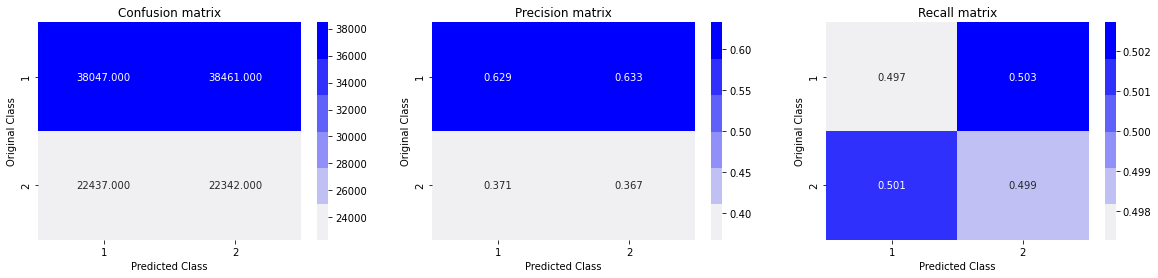

In [92]:
import random
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

 14%|███████████▌                                                                     | 1/7 [15:03<1:30:20, 903.49s/it]

For values of alpha =  1e-05 The log loss is: 0.44580707620181625


 29%|███████████████████████▏                                                         | 2/7 [28:28<1:10:27, 845.50s/it]

For values of alpha =  0.0001 The log loss is: 0.45133485261622985


 43%|███████████████████████████████████▌                                               | 3/7 [34:34<41:46, 626.70s/it]

For values of alpha =  0.001 The log loss is: 0.45284140645082827


 57%|███████████████████████████████████████████████▍                                   | 4/7 [35:44<20:20, 406.99s/it]

For values of alpha =  0.01 The log loss is: 0.4198946309047708


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [36:11<08:59, 269.94s/it]

For values of alpha =  0.1 The log loss is: 0.43741460240719954


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [36:30<03:04, 184.56s/it]

For values of alpha =  1 The log loss is: 0.47081297879101613


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [36:44<00:00, 314.99s/it]

For values of alpha =  10 The log loss is: 0.5134984151183415


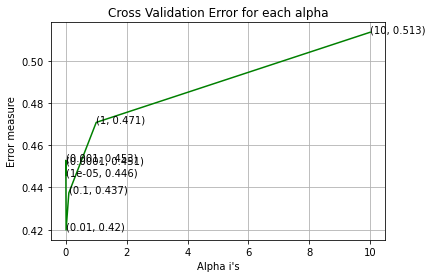

For values of best alpha =  0.01 The train log loss is: 0.41904761601053125
For values of best alpha =  0.01 The test log loss is: 0.4198946309047708
Total number of data points : 121287


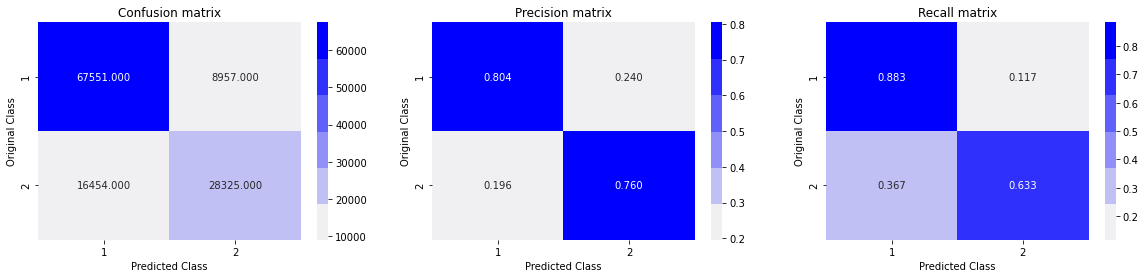

In [96]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparameter
log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM

 14%|███████████▍                                                                    | 1/7 [26:46<2:40:36, 1606.02s/it]

For values of alpha =  1e-05 The log loss is: 0.44159564038584986


 29%|██████████████████████▊                                                         | 2/7 [56:16<2:21:53, 1702.71s/it]

For values of alpha =  0.0001 The log loss is: 0.4445845355463605


 43%|█████████████████████████████████▍                                            | 3/7 [1:25:15<1:54:37, 1719.39s/it]

For values of alpha =  0.001 The log loss is: 0.5083928861473176


 57%|████████████████████████████████████████████▌                                 | 4/7 [1:56:38<1:29:12, 1784.08s/it]

For values of alpha =  0.01 The log loss is: 0.5198990234270008


 71%|█████████████████████████████████████████████████████████▏                      | 5/7 [2:19:39<54:37, 1638.65s/it]

For values of alpha =  0.1 The log loss is: 0.5046357999732324


 86%|████████████████████████████████████████████████████████████████████▌           | 6/7 [3:17:48<37:47, 2267.85s/it]

For values of alpha =  1 The log loss is: 0.6075394116741972


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [3:37:42<00:00, 1866.01s/it]

For values of alpha =  10 The log loss is: 0.6508622466420806


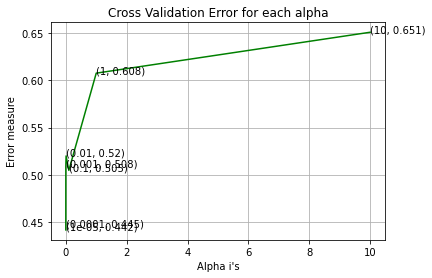

For values of best alpha =  1e-05 The train log loss is: 0.43883668372793055
For values of best alpha =  1e-05 The test log loss is: 0.44159564038584986
Total number of data points : 121287


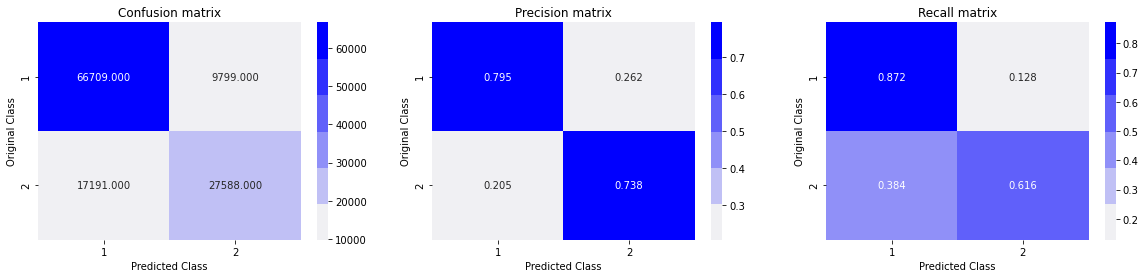

In [97]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparameter
log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost

In [98]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68487	valid-logloss:0.68485
[10]	train-logloss:0.61536	valid-logloss:0.61555
[20]	train-logloss:0.56434	valid-logloss:0.56469
[30]	train-logloss:0.52605	valid-logloss:0.52656
[40]	train-logloss:0.49639	valid-logloss:0.49704
[50]	train-logloss:0.47348	valid-logloss:0.47425
[60]	train-logloss:0.45517	valid-logloss:0.45606
[70]	train-logloss:0.44050	valid-logloss:0.44153
[80]	train-logloss:0.42872	valid-logloss:0.42978
[90]	train-logloss:0.41920	valid-logloss:0.42038
[100]	train-logloss:0.41121	valid-logloss:0.41244
[110]	train-logloss:0.40456	valid-logloss:0.40581
[120]	train-logloss:0.39897	valid-logloss:0.40028
[130]	train-logloss:0.39423	valid-logloss:0.39560
[140]	train-logloss:0.39024	valid-logloss:0.39171
[150]	train-logloss:0.38715	valid-logloss:0.38865
[160]	train-logloss:0.38424	valid-logloss:0.38582
[170]	train-logloss:0.38158	valid-logloss:0.38323
[180]	train-logloss:0.37921	valid-logloss:0.38095
[190]	train-logloss:0.37704	valid-logloss:0.37884
[200]	train

Total number of data points : 121287


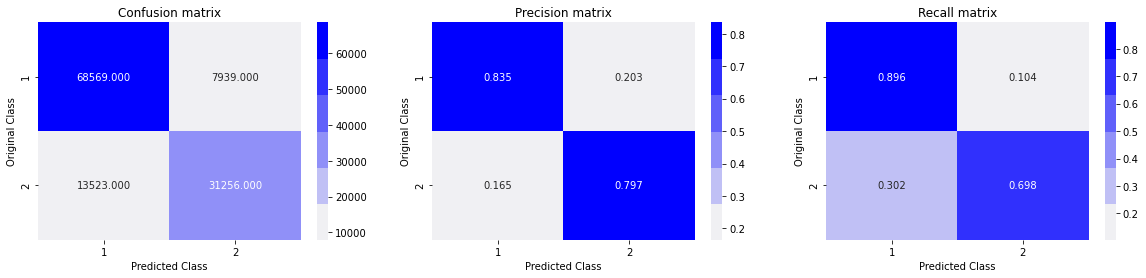

0.8230478122140048

In [100]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
accuracy_score(y_test, predicted_y)